In [ ]:
Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.

Подберите параметры модели SARIMAX для этого ряда.

Сделайте вывод о том, как изменилась модель по сравнению с недельной.

Постройте ACF, PACF и модель ARIMA для BRENT (lнедельный )

Оцените результат моделирования

Сделайте предположение о моделях, которые лучше работают с техниками регрессии на основе AR I MA.

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os

import itertools

In [6]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

from random import random
import warnings
warnings.filterwarnings("ignore") # отключает предупреждения

## Энергия

In [4]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


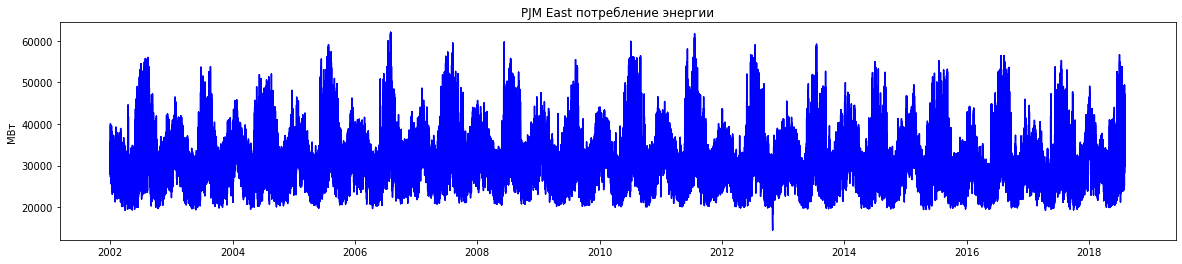

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data.index, data['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
data_m = data.copy().resample('M').mean()

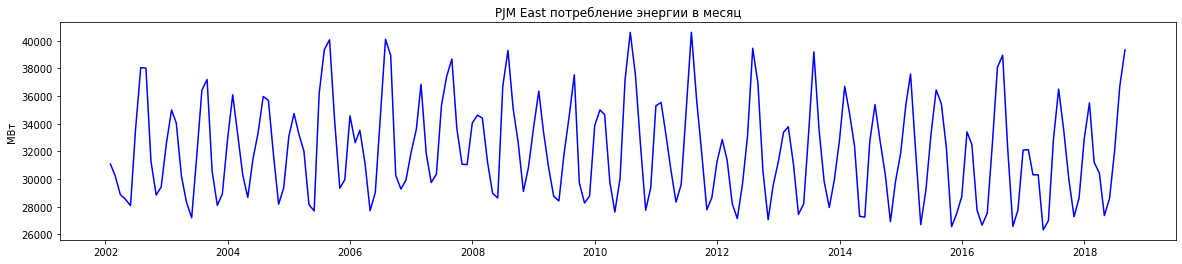

In [11]:
plt.figure(figsize =(20,4))
plt.plot( data_m.index, data_m['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии в месяц' )
plt.ylabel ( 'МВт' )
plt.show()

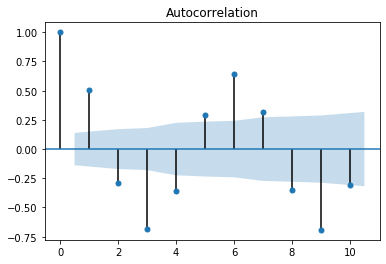

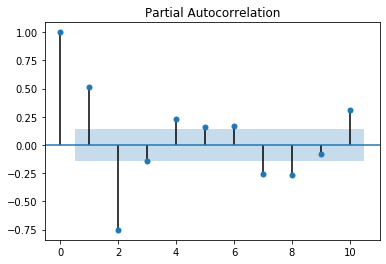

In [43]:
sm.graphics.tsa.plot_acf(data_m['PJME_MW'].values[:800], lags=10)
plt.show()

sm.graphics.tsa.plot_pacf(data_m['PJME_MW'].values[:800], lags=10)
plt.show()

In [69]:
# Определим p, d и q 
q = 2
p = 2
d = 2
pdq = [p, d, q]
# определим комбинации сезонных параметров p, q и q, 
qs = 0
ps = 0
ds = 0
seasonal_pdq = [ps, ds, qs ,3] 

In [70]:
print('SARIMAX: p,d,q=',pdq,'   : ps,ds,qs, S=', seasonal_pdq)

SARIMAX: p,d,q= [2, 2, 2]    : ps,ds,qs, S= [0, 0, 0, 3]


In [71]:
N1 = 0  # берем дданные не от начала - так быстрее работает
N2=50  # число точек для теста
nforecast = N2+30

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=pdq,
                                seasonal_order=seasonal_pdq ,
                                enforce_stationarity= False ,
                                enforce_invertibility=False)
results = mod.fit()
print('SARIMAX{}x{} - AIC:{}'.format(pdq, seasonal_pdq, results.aic))

SARIMAX[2, 2, 2]x[0, 0, 0, 3] - AIC:2657.940471532607


In [72]:
print(results.summary().tables[0],results.summary().tables[1])

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  150
Model:               SARIMAX(2, 2, 2)   Log Likelihood               -1323.970
Date:                Sun, 08 Nov 2020   AIC                           2657.940
Time:                        19:13:12   BIC                           2672.824
Sample:                             0   HQIC                          2663.988
                                - 150                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8717      0.107      8.112      0.0

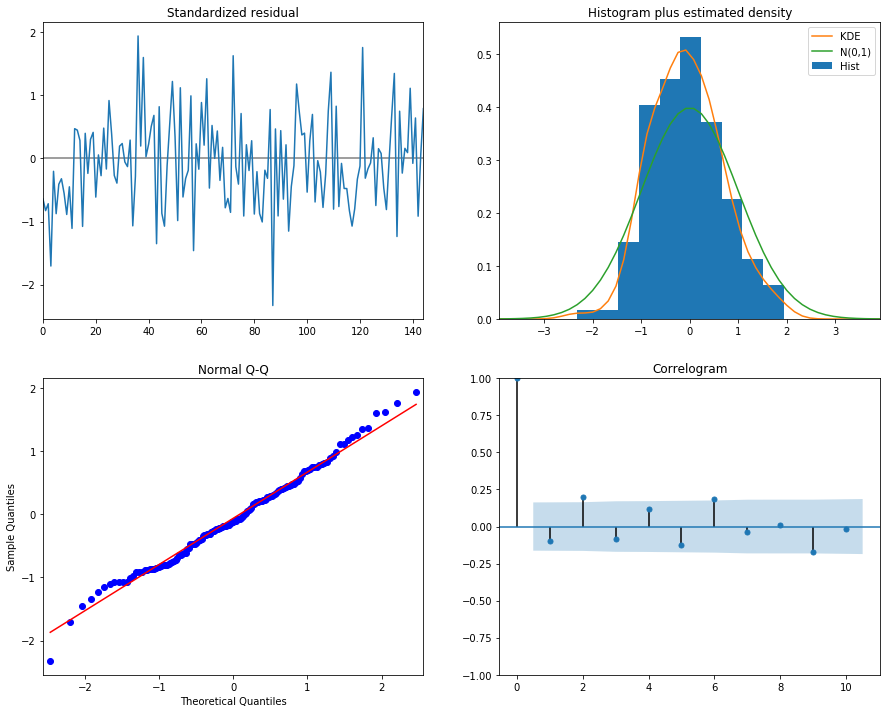

In [73]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [74]:
# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q

p = range(0, 3) 
d = range(0, 3)
q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 3)
SARIMAX: (0, 0, 1) x (0, 0, 0, 3)
SARIMAX: (0, 0, 2) x (0, 0, 0, 3)
SARIMAX: (0, 0, 2) x (0, 0, 1, 3)


In [79]:
warnings.filterwarnings("ignore") # отключает предупреждения
res = {}
min_aic = 1000000000
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[0:-30],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < min_aic:
                min_aic = results.aic
                res['ARIMA'] = param
                res['Seasonal'] = param_seasonal
                res['AIC'] = results.aic
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 3)3 - AIC:3992.5110075928433
ARIMA(0, 0, 0)x(0, 0, 1, 3)3 - AIC:3829.988003091478
ARIMA(0, 0, 0)x(0, 0, 2, 3)3 - AIC:3716.946328994067
ARIMA(0, 0, 0)x(0, 1, 0, 3)3 - AIC:3386.226848111379
ARIMA(0, 0, 0)x(0, 1, 1, 3)3 - AIC:3237.080871581555
ARIMA(0, 0, 0)x(0, 1, 2, 3)3 - AIC:3038.4974394223846
ARIMA(0, 0, 1)x(0, 0, 0, 3)3 - AIC:3849.2578786438085
ARIMA(0, 0, 1)x(0, 0, 1, 3)3 - AIC:3761.159868223867
ARIMA(0, 0, 1)x(0, 0, 2, 3)3 - AIC:3678.4408503614136
ARIMA(0, 0, 1)x(0, 1, 0, 3)3 - AIC:3295.5877528732344
ARIMA(0, 0, 1)x(0, 1, 1, 3)3 - AIC:3183.142272856492
ARIMA(0, 0, 1)x(0, 1, 2, 3)3 - AIC:2939.7018198126443
ARIMA(0, 0, 2)x(0, 0, 0, 3)3 - AIC:3799.369172261455
ARIMA(0, 0, 2)x(0, 0, 1, 3)3 - AIC:3724.9066059281977
ARIMA(0, 0, 2)x(0, 0, 2, 3)3 - AIC:3654.3741410641023
ARIMA(0, 0, 2)x(0, 1, 0, 3)3 - AIC:3240.159033882229
ARIMA(0, 0, 2)x(0, 1, 1, 3)3 - AIC:3016.205910959959
ARIMA(0, 0, 2)x(0, 1, 2, 3)3 - AIC:2898.8382898090904
ARIMA(0, 1, 0)x(0, 0, 0, 3)3 - AIC:32

ARIMA(2, 2, 1)x(0, 1, 1, 3)3 - AIC:3058.822525323083
ARIMA(2, 2, 1)x(0, 1, 2, 3)3 - AIC:2974.0510482255304
ARIMA(2, 2, 2)x(0, 0, 0, 3)3 - AIC:3018.578244993625
ARIMA(2, 2, 2)x(0, 0, 1, 3)3 - AIC:2962.8394420044424
ARIMA(2, 2, 2)x(0, 0, 2, 3)3 - AIC:2909.045001751389
ARIMA(2, 2, 2)x(0, 1, 0, 3)3 - AIC:3185.656813325826
ARIMA(2, 2, 2)x(0, 1, 1, 3)3 - AIC:3112.1800100573055
ARIMA(2, 2, 2)x(0, 1, 2, 3)3 - AIC:3051.4023772996143


In [80]:
res

{'ARIMA': (2, 1, 2), 'Seasonal': (0, 0, 2, 3), 'AIC': 2861.690532033508}

In [91]:
N1 = 0   # берем дданные не от начала - так быстрее работает
N2=50  # число точек для теста
nforecast = N2+50

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[N1:-N2],order=[2,1,2],
                                seasonal_order=[0,0,2,3] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt = mod.fit()
print(f'AIC:{results_opt.aic}')


AIC:2508.1216273363398


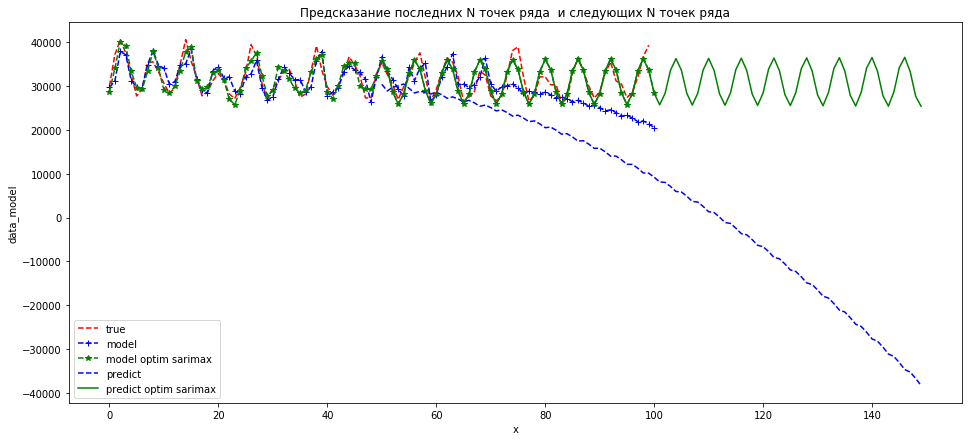

In [92]:
nforecast = N2  # полное число предиктов (тест+ чистый предикт)
N4 = 50
y_p = results.predict(len(data_m['PJME_MW'].values[N1:-N2])-N4, N4+len(data_m['PJME_MW'].values[N1:-N2]), typ='levels')
y_ps = results_opt.predict(len(data_m['PJME_MW'].values[N1:-N2])-N4, N4+len(data_m['PJME_MW'].values[N1:-N2]), typ='levels')
y_f = results.forecast(2*N2 )
y_fs = results_opt.forecast(2*N2 )

plt.figure(figsize=(16,7))
plt.plot(data_m['PJME_MW'].values[-N2*2:],'--r',label ='true')
plt.plot(range(N2-N4,N2+N4+1),y_p,'+--b',label ='model')
plt.plot(range(N2-N4,N2+N4+1),y_ps,'*--g',label ='model optim sarimax')
plt.plot(np.arange(2*N2)+N2,y_f,'--b',label ='predict')
plt.plot(np.arange(2*N2)+N2,y_fs,'g',label ='predict optim sarimax')

plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

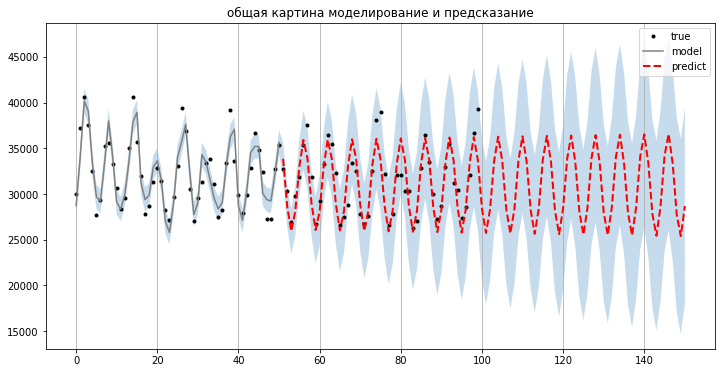

In [98]:
N3=100  # отступ данных для отображения  модели (для улучшения визуальных качеств рисунка - берем из интервала [0-500])
nforecast = N2+50  # общее число точек для предсказания (N2 - тестовых точек + точки для чистого предсказания)
predict_ = results_opt.get_prediction(end=results_opt.nobs + nforecast)  # делаем предсказание

# отображаем
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.xaxis.grid()
ax.plot(data_m['PJME_MW'].values[N3+N1:], 'k.',label='true')

# 
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], 'gray',label = 'model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2, label='predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.25)
plt.legend()
ax.set(title='общая картина моделирование и предсказание');

## Нефть

In [7]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


Text(0.5, 0, 't')

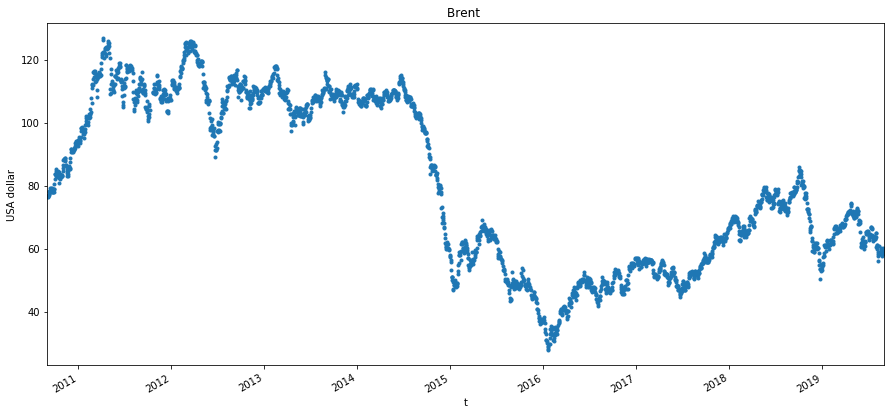

In [8]:
_ = brent_data['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [9]:
brent_data_w = brent_data.copy().resample('W').mean()

In [10]:
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


Text(0.5, 0, 't')

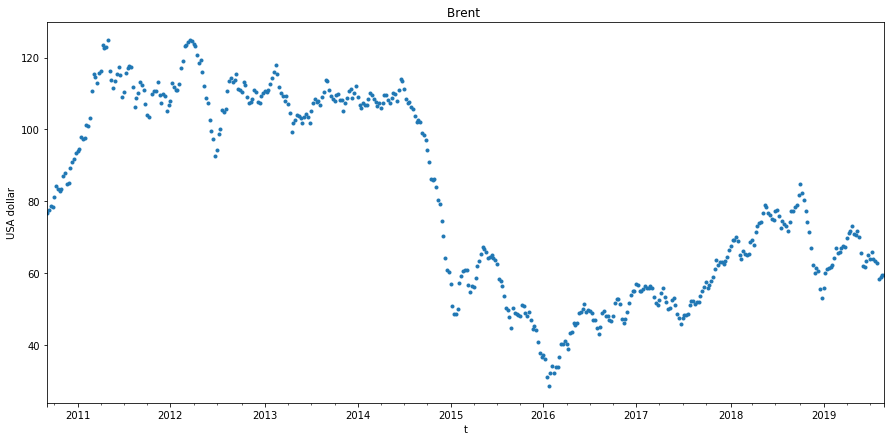

In [11]:
_ = brent_data_w['Значение'].plot( style='.', figsize=( 15, 7 ), title='Brent ')
plt.ylabel('USA dollar')
plt.xlabel('t')

In [12]:
len(brent_data_w['Значение'].values)

470

In [13]:
brent_data_w['Значение'].values

array([ 76.616     ,  77.67333333,  78.69333333,  78.51833333,
        81.21166667,  84.14666667,  83.49833333,  82.795     ,
        83.36166667,  87.00333333,  87.77666667,  84.76833333,
        85.07333333,  89.31166667,  90.954     ,  91.63666667,
        93.53833333,  93.96833333,  94.558     ,  97.83333333,
        97.44      ,  97.71333333, 101.12166667, 101.03666667,
       103.03666667, 110.68666667, 115.305     , 114.45      ,
       112.93166667, 115.565     , 116.248     , 123.38333333,
       122.57      , 123.078     , 124.78833333, 116.16666667,
       113.86833333, 111.495     , 113.438     , 115.54833333,
       117.29833333, 115.18833333, 109.14333333, 110.51166667,
       115.57166667, 116.98166667, 117.72166667, 117.425     ,
       111.72833333, 106.16833333, 108.84333333, 110.20166667,
       113.29166667, 112.36666667, 110.94666667, 107.10666667,
       103.87833333, 103.47666667,          nan, 109.75666667,
       110.68      , 110.82      , 113.225     , 109.56

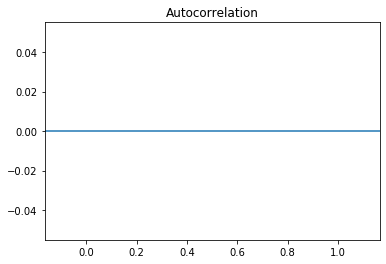

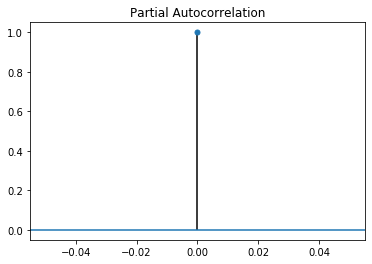

In [14]:
sm.graphics.tsa.plot_acf(brent_data_w['Значение'], lags=100)
plt.show()
sm.graphics.tsa.plot_pacf(brent_data_w['Значение'], lags=100)
plt.show()

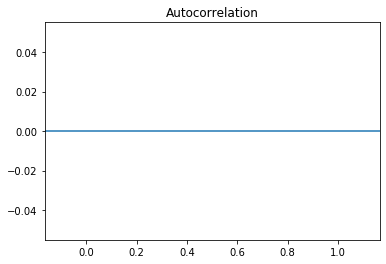

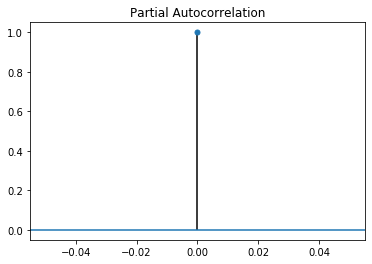

In [15]:
#plt.figure(figsize=(20,8))
#plt.subplot(2,1,1)
brent_dif_w = brent_data_w['Значение'].diff(1)

sm.graphics.tsa.plot_acf(brent_dif_w[1:], lags=30)
plt.show()
#plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(brent_dif_w[1:], lags=30)
plt.show()

In [16]:
# Определим p, d и q 
q = 1
p = 2
d = 1
pdq = [p, d, q]

N2=30
warnings.filterwarnings("ignore") # отключает предупреждения

modb = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=pdq,seasonal_order=[0,0,0,0], trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb = modb.fit()
print('ARIMA{} - AIC:{}'.format(pdq, resultsb.aic))

print(resultsb.summary().tables[0],resultsb.summary().tables[1])

ARIMA[2, 1, 1] - AIC:1908.2969942776867
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  440
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -948.148
Date:                Sun, 08 Nov 2020   AIC                           1908.297
Time:                        20:08:10   BIC                           1932.777
Sample:                             0   HQIC                          1917.957
                                - 440                                         
Covariance Type:                  opg                                         
============================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   

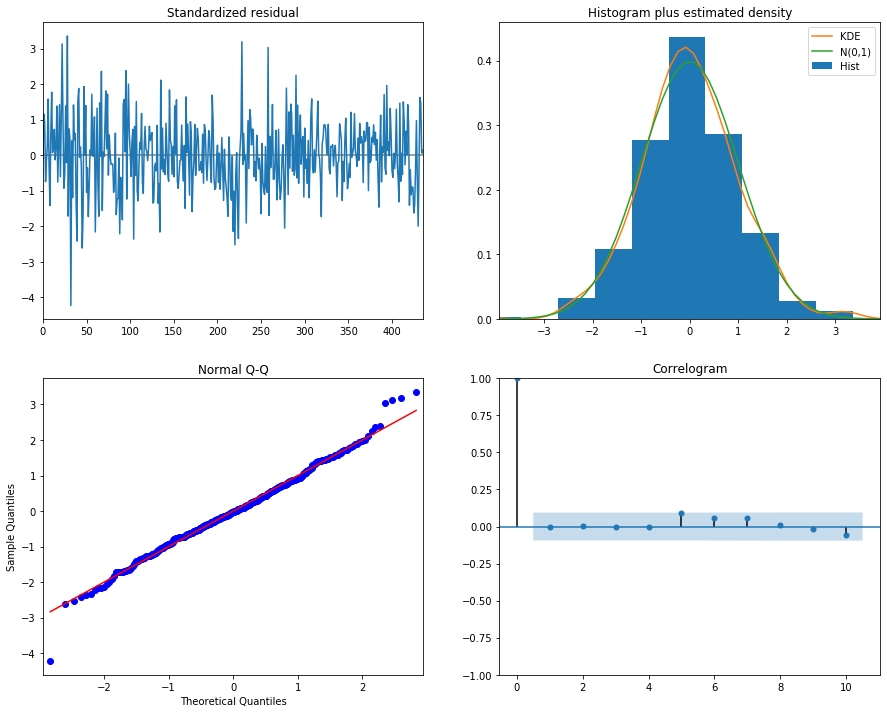

In [17]:
resultsb.plot_diagnostics(figsize=(15, 12))
plt.show()

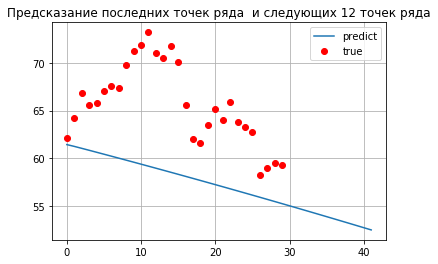

In [143]:
pred_dynamic = resultsb.forecast(42)    #делаем предсказание на 3 точки от текущего конца ряда

plt.plot(pred_dynamic, label='predict' )
#Отобразим истинный значения 
plt.plot(brent_data_w['Значение'].values[-30:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 12 точек ряда')
plt.legend()
plt.grid()
plt.plot()
plt.show()

In [19]:
import itertools
# Определим p, d и q в диапазоне 0-3
d = range(0, 4)
p = range(0, 4)
q = range(0, 4)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [0,0,0,0] # нет сезона

warnings.filterwarnings("ignore") # отключает предупреждения

for param in pdq:
    param_seasonal = seasonal_pdq
    try:
        mod_b = sm.tsa.statespace.SARIMAX(np.log(brent_data_w['Значение'].values[:-100]),
                                          order=param,seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)

        results_ = mod_b.fit()
        print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_.aic))
    except:
        continue

ARIMA(0, 0, 0)x[0, 0, 0, 0] - AIC:-34.365974453088725
ARIMA(0, 0, 1)x[0, 0, 0, 0] - AIC:-492.4668336899833
ARIMA(0, 0, 2)x[0, 0, 0, 0] - AIC:-810.3347298643189
ARIMA(0, 0, 3)x[0, 0, 0, 0] - AIC:-585.6023223267823
ARIMA(0, 1, 0)x[0, 0, 0, 0] - AIC:-1455.0581244605282
ARIMA(0, 1, 1)x[0, 0, 0, 0] - AIC:-1490.5494066479466
ARIMA(0, 1, 2)x[0, 0, 0, 0] - AIC:-1483.6869561839126
ARIMA(0, 1, 3)x[0, 0, 0, 0] - AIC:-1478.7219259057056
ARIMA(0, 2, 0)x[0, 0, 0, 0] - AIC:-1332.4159521021638
ARIMA(0, 2, 1)x[0, 0, 0, 0] - AIC:-1398.194849850672
ARIMA(0, 2, 2)x[0, 0, 0, 0] - AIC:-1460.3407030258327
ARIMA(0, 2, 3)x[0, 0, 0, 0] - AIC:-1451.103175663635
ARIMA(0, 3, 0)x[0, 0, 0, 0] - AIC:-983.4919652239623
ARIMA(0, 3, 1)x[0, 0, 0, 0] - AIC:-1278.8616321516283
ARIMA(0, 3, 2)x[0, 0, 0, 0] - AIC:-1221.0409684556118
ARIMA(0, 3, 3)x[0, 0, 0, 0] - AIC:-1178.7687069314834
ARIMA(1, 0, 0)x[0, 0, 0, 0] - AIC:-1463.2949926492445
ARIMA(1, 0, 1)x[0, 0, 0, 0] - AIC:-1498.9597246518044
ARIMA(1, 0, 2)x[0, 0, 0, 0] - AIC:

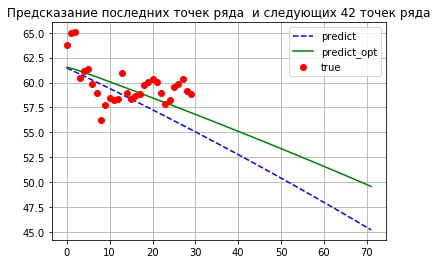

In [27]:

N2=30
nforecast = N2+42

modb_opt = sm.tsa.statespace.SARIMAX(brent_data_w['Значение'].values[:-N2],
                               order=[3,1,2],seasonal_order=[0,0,0,0],trend='ct',
                               enforce_stationarity=False,
                               enforce_invertibility=False)
resultsb_opt = modb_opt.fit()
pred_dynamic = resultsb.forecast(nforecast)    #делаем предсказание c 30 точки от текущего конца ряда
pred_dynamic_opt = resultsb_opt.forecast(72) 

plt.plot(pred_dynamic,'--b', label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(brent_data['Значение'].values[-N2:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 42 точек ряда')
plt.legend()
plt.grid()
plt.show()

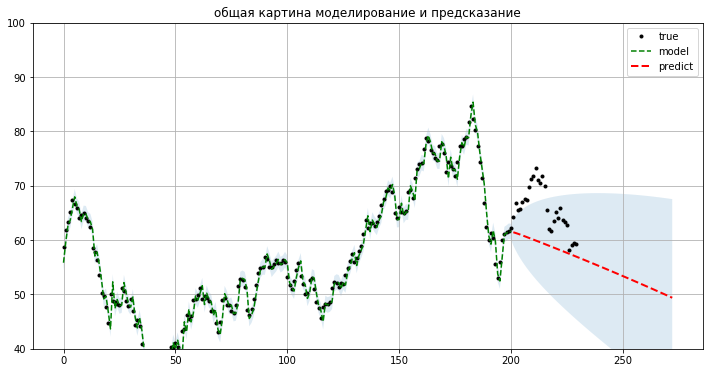

In [28]:
N2=30 # число точек для теста
nforecast = N2+42  # общее число точек для предсказания (тест+ чистое предсказание)
N3=240  # отступ от начала известной информации для визуализации - так виднее (можно брать 0-2600)
predict_ = resultsb_opt.get_prediction(end=resultsb_opt.nobs + nforecast)   
# получаем результаты работы модели по всей выборке

# отображаем результаты
idx = np.arange(len(predict_.predicted_mean)-N3)
predict_ci = predict_.conf_int(alpha=0.5)

#
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(brent_data_w['Значение'].values[N3:], 'k.',label='true')
plt.ylim([40,100])
plt.grid()
ax.plot(idx[:-nforecast], predict_.predicted_mean[N3:-nforecast], '--g',label='model')
ax.plot(idx[-nforecast:], predict_.predicted_mean[-nforecast:], 'r--', linestyle='--', linewidth=2,label = 'predict')
ax.fill_between(idx, predict_ci[N3:, 0], predict_ci[N3:, 1], alpha=0.15)
plt.legend()

ax.set(title='общая картина моделирование и предсказание');

## Результат

1. Что касается ряда с энергией - то всё отлично. Сезонные периодичные ряды работают и хорошо предсказываются.
2. Что касается ряда с нефтью - то всё плохо. Угадыватеся общий вектор, не более. Да и то на практике в силу политических аспектов предсказывать нефть невозможно. 